# Introduction to `laplax` for regression tasks

This tutorial follows the `laplace-torch` regression tutorial and provides a quick overview of the different functionalities which are currently supported by `laplax`.

For the dataset we consider sinus as our target with additional observation noise $\sigma^2 = 0.3$. To make the task harder, we only consider training and validation data on a few subintervals.

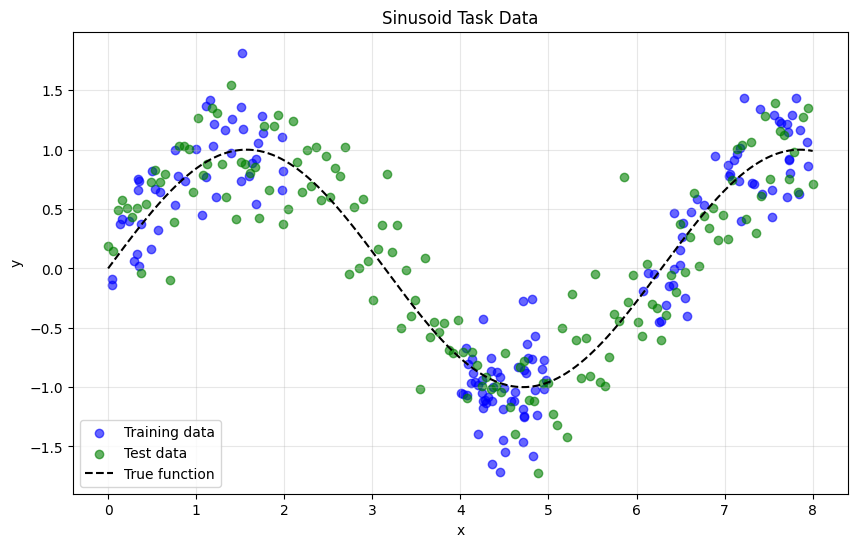

In [92]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example
from plotting import plot_sinusoid_task
jax.config.update("jax_enable_x64", False)

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
num_calibration_samples = 50
num_test_samples = 150

batch_size = 20
X_train, y_train, X_valid, y_valid, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=0.3,
    intervals=[(0, 2), (4, 5), (6, 8)],
    rng_key=jax.random.key(0)
)
train_loader = DataLoader(X_train, y_train, batch_size)

fig = plot_sinusoid_task(X_train, y_train, X_test, y_test)

## Training for the MAP

In this tutorial, we use `flax.nnx` for setting up neural networks in `jax`, but other libraries (e.g., `equinox` or `flax.linen`) should also work out of the box since we will only require a split into `model_fn` and `params` for `laplax`, which all of them provide.

From a Bayesian perspective supervised learning can be seen as finding the maximum-a-posteriori estimate of the joint log likelihood:

$$ \text{arg}\max_{\theta_\in\mathbb{R}^{P}} = \sum_{n=1}^{N} \log p(y_n \vert f(x_n, \theta) )+ \log p(\theta) $$

where:
- $f$ is the neural network,
- $\theta \in \mathbb{R}^{P}$ its parameters, and
- $\mathcal{D} := \{(x_n, y_n)\}_{n=1}^{N}$ the labelled dataset.

In [93]:
# Create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = self.linear2(nnx.tanh(self.linear1(x)))
        return x


@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)  # Call methods directly
        return jnp.sum((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # Inplace updates

    return loss


def train_model(model, n_epochs, lr=1e-3):
    # Create optimizer
    optimizer = nnx.Optimizer(model, optax.adamw(lr))  # Reference sharing

    # Train epoch
    for epoch in range(n_epochs):
        for x_tr, y_tr in train_loader:
            loss = train_step(model, optimizer, x_tr, y_tr)

        if epoch % 100 == 0:
            print(f"[epoch {epoch}]: loss: {loss:.4f}")

    print(f"Final loss: {loss:.4f}")
    return model

[epoch 0]: loss: 6.2626
[epoch 100]: loss: 4.2591
[epoch 200]: loss: 1.3689
[epoch 300]: loss: 1.5673
[epoch 400]: loss: 0.3712
[epoch 500]: loss: 0.6099
[epoch 600]: loss: 1.7761
[epoch 700]: loss: 0.5140
[epoch 800]: loss: 0.5963
[epoch 900]: loss: 0.6607
Final loss: 0.8118


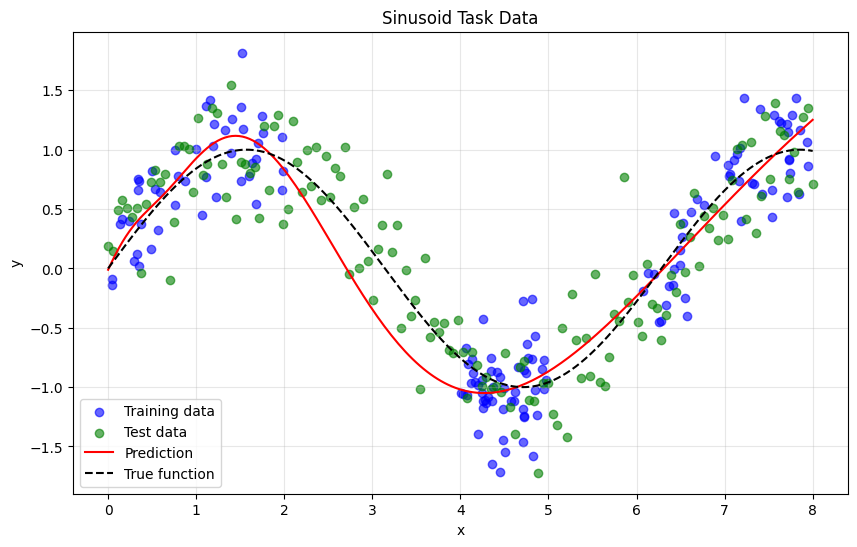

In [94]:
# Initialize model
model = Model(in_channels=1, hidden_channels=64, out_channels=1, rngs=nnx.Rngs(0))

# Train model
model = train_model(model, n_epochs=1000)

X_pred = jnp.linspace(0., 8., 200).reshape(200, 1)
y_pred = jax.vmap(model)(X_pred)

_ = plot_sinusoid_task(X_train, y_train, X_test, y_test, X_pred, y_pred)

## Estimating the curvature

We are now interested in finding a normal distribution that describes the uncertainty in the weight space with respect to the loss and the data:
$$ p(\theta \vert \mathcal{D}) = \frac{p(\mathcal{D}, \theta)}{p(\mathcal{D})} = \frac{p(\mathcal{D} \vert \theta) p(\theta)}{\int p(\mathcal{D} \vert \theta) p(\theta) d\theta}. $$

Our tool of choice is the Laplace approximation --- motivated via a second-order Taylor expansion, where the first-order term disappears due to the assumption of having reached a local minimum of the loss. Following these steps we get the following normal distribution approximating the true posterior:
$$ \theta \sim \mathcal{N}(\theta_{\text{MAP}}, [\nabla^2_{\theta\theta} \log p(\theta \vert \mathcal{D}) \vert_{\theta = \theta_{\text{MAP}}} ]^{-1}). $$

We usually assume the prior to be an isotropic Gaussian distribution, hence the expensive part remains mainly the loss hessian. Due to various reasons (positive definiteness or/and a linearized perspective of the neural network) we usually consider instead of the true Hessian the so-called Generalized-Gauss Newton matrix:

$$ \text{GGN}(f, \theta, \mathcal{D}) = \sum_{n=1}^{N} \mathcal{J}_\theta f(x_n)^\top \nabla^2_{\theta\theta}\ell(f_\theta(x_n), y_n) \mathcal{J}_\theta f(x_n).$$ 

We start by splitting the `flax.nnx` model into `model_fn` and `params`. **Important** The signature of the `model_fn` needs to be `input` and `params`, since we strongly depend on the key word arguments in `laplax`.

In [95]:
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = {"input": X_train, "target": y_train}

ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="mse",
)

In this small toy example, we can dense the curvature matrix-vector product. We start by wrapping the matrix-vector product to accept normal 1D vectors of size $P$. This will help us visualize the GGN.

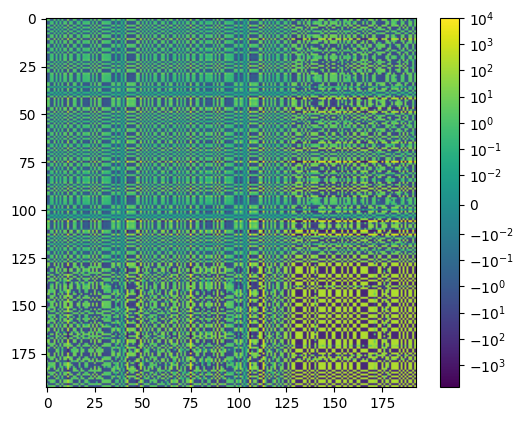

In [96]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from laplax.util.flatten import flatten_function
from laplax.util.mv import to_dense
from laplax.util.tree import get_size

ggn_mv_wrapped = flatten_function(ggn_mv, layout=params)
arr = to_dense(ggn_mv_wrapped, layout=get_size(params))


plt.imshow(arr, norm=SymLogNorm(linthresh=1e-2, linscale=1))
plt.colorbar()
plt.show()

## Curvature estimators

In practice, we can not afford to dense and continue computations with the GGN. Therefore, various strategies for estimating the curvature exist. Within this package we have: `full` (obvious), `diagonal` and low_rank. For the latter, we support finding the low rank representation using `lanczos` or `lobpcg`. 

In [99]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for library selection.
lib_dropdown = widgets.Dropdown(
    options=['full', 'diagonal', 'lanczos', 'lobpcg'],
    value='lanczos',
    description='Curv. est.:',
)
display(lib_dropdown)

Dropdown(description='Curv. est.:', index=2, options=('full', 'diagonal', 'lanczos', 'lobpcg'), value='lanczos…

In [102]:
from laplax.curv import estimate_curvature

print(f"Curvature will be estimated using a {lib_dropdown.value} approximation.")
curv_type = lib_dropdown.value
low_rank_args = {
    "key": jax.random.key(20),
    "rank": 50,
    "mv_jittable": True,
}
curv_args = {} if curv_type in {"full", "diagonal"} else low_rank_args

curv_estimate = estimate_curvature(
    curv_type=curv_type,
    mv=ggn_mv,
    layout=params,
    **curv_args,
)
curv_estimate.U.shape

Curvature will be estimated using a lanczos approximation.


(193, 50)

## Create a posterior_fn

We can now create a `posterior_fn` that takes `prior_arguments` and returns a posterior distribution over the weights. This includes adding the prior precision $\tau$ and inverting the combined expression in a memory-efficient way:
$$ \text{posterior\_fn}(\tau) = \big( GGN + \tau I_{P\times P} \big)^{-1} $$
If we have already an estimation of the curvature, then we can directly set the posterior function using the estimate. Otherwise both functions can also be executed at once using the `laplax.curv.create_posterior_fn`. 

In [90]:
from laplax.curv.cov import set_posterior_fn

posterior_fn = set_posterior_fn(curv_type, curv_estimate, layout=params)

# # Alternatively, we can create the posterior function from scratch, if no curvature
# # estimation is available.
# # Create Posterior
# posterior_fn = create_posterior_fn(
#     curv_type=curv_type,
#     mv=ggn_mv,
#     layout=params,
#     **curv_args,
# )
posterior_fn

<function laplax.curv.cov.set_posterior_fn.<locals>.posterior_fn(prior_arguments: collections.abc.Mapping[str, jax.Array | float], loss_scaling_factor: jaxtyping.Float = 1.0) -> jaxtyping.PyTree[jaxtyping.Num[Array, '...']]>

## How to pushforward the weight space uncertainty?

There are two ideas for pushing forward weight space uncertainty.

1. Sample-based pushforward via the neural network
$$ f(x_n, \theta_s), \quad \theta_s \sim \mathcal{N}\bigg(\theta_{MAP}, \Sigma\bigg)$$

2. Linearized pushforward
$$ f(x_n, \theta) \sim \mathcal{N}\bigg(f(x_n, \theta_{MAP}), \mathcal{J}_{\theta}(f(x_n, \theta_{\text{MAP}}))\Sigma \mathcal{J}_{\theta}(f(x_n, \theta_{\text{MAP}}))^\top\bigg)$$

**Recommendation:** Play around with the prior precision to see its strong modeling impact. Also check out larger intervals to see the uncertainty structure outside of the training domain.

### Sample-based pushforward via the neural network

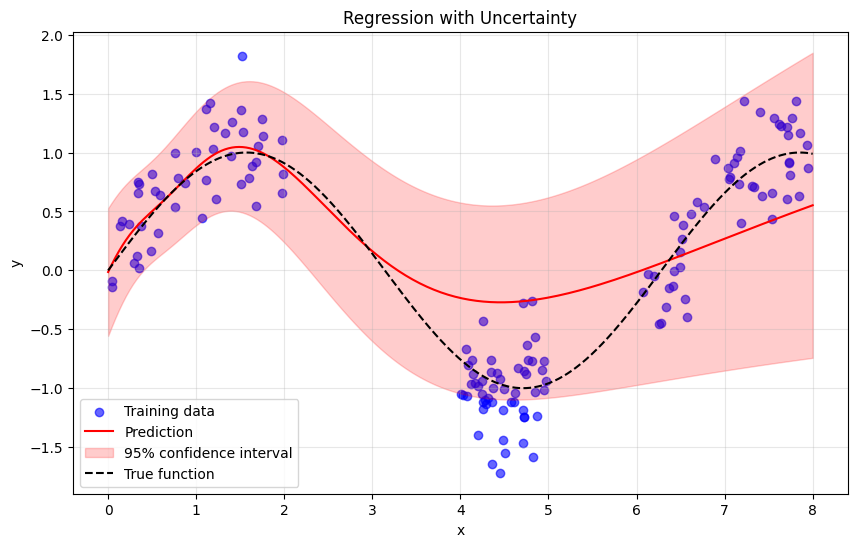

In [68]:
from functools import partial

from plotting import plot_regression_with_uncertainty

from laplax.eval.pushforward import (
    nonlin_pred_mean,
    nonlin_pred_std,
    nonlin_pred_var,
    nonlin_setup,
    set_nonlin_pushforward,
)

# Setup linearized pushforward
set_nonlin_prob_predictive = partial(
    set_nonlin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        nonlin_setup,
        nonlin_pred_mean,
        nonlin_pred_var,
        nonlin_pred_std
    ],
    key=jax.random.key(42),
    num_samples=10000,
)
prior_arguments = {"prior_prec": 40.}  # Choose any prior precision.
prob_predictive = set_nonlin_prob_predictive(
    prior_arguments=prior_arguments,
)

X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0]),
)

### Linearized pushforward

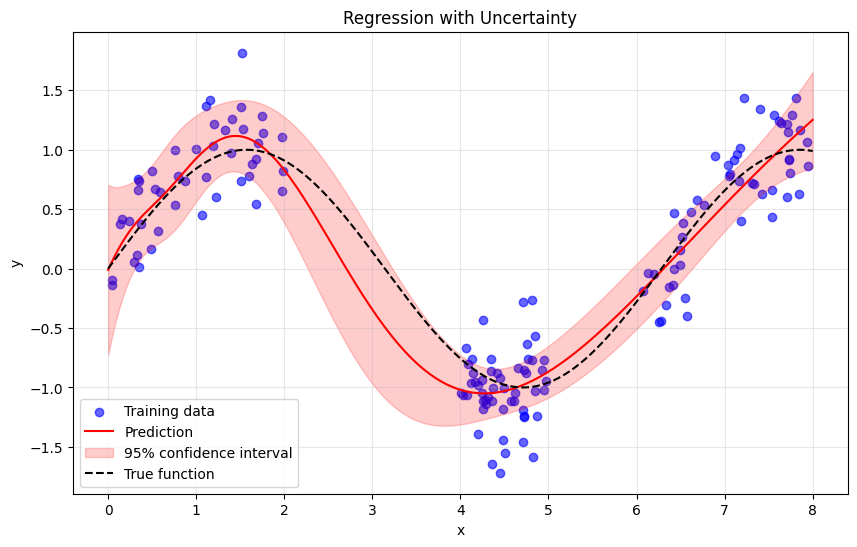

In [69]:
from functools import partial

from plotting import plot_regression_with_uncertainty

from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_pred_var,
    lin_setup,
    set_lin_pushforward,
)

# Setup linearized pushforward
set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_var,
        lin_pred_std,
    ],
)
prior_arguments = {"prior_prec": 1.}  # Choose any prior precision.
prob_predictive = set_prob_predictive(
    prior_arguments=prior_arguments,
)

X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

## Calibration

When playing around we see that it is non-trivial of how to choose the prior precision. To do so with an heuristic we need to optimize some objective. There are two common strategies: either optimize for a downstream metric (e.g. Negative-Log Likelihood or average calibration ($\chi^2$)) or target the marginal log-likelihood. Later is a common objective for even more general model selection (see below) and is given by:

$$ \log p(\mathcal{D}\vert\mathcal{M}) = \log p(\mathcal{D} \vert \theta_{*}, \mathcal{M}) + \log p(\mathcal{\theta_*} \vert \mathcal{M}) - \frac{1}{2} \log \vert \frac{1}{2\pi} \mathrm{H}_{\theta_*}\vert $$

where $\mathrm{H}_{\theta_*}$ is the posterior precision and $\mathcal{M}$ other model parameters, such as the network architecture. We note that no inversion is needed compute the marginal log likelihood when updating the prior arguments. However, in practice optimizing for downstream metrics will also lead to better downstream metrics.

For optimization we can choose either grid search or gradient descent.

### Partially initializing `set_prob_predictive`


We always start by partially initializing the `set_prob_predictive`, such that it only misses the `prior_arguments`, which we will use for optimizing a chosen objective.

In [70]:
from functools import partial

from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_setup,
    set_lin_pushforward,
)

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_std,
    ],
)

# Set a batch of calibration data
clbr_batch = {"input": X_valid, "target": y_valid}

### Select calibration objective

In [71]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for library selection.
clbr_obj_dropdown = widgets.Dropdown(
    options=['nll', 'chi_squared', 'marginal log-likelihood'],
    value='nll',
    description='Objective:',
)
display(clbr_obj_dropdown)

Dropdown(description='Objective:', options=('nll', 'chi_squared', 'marginal log-likelihood'), value='nll')

In [72]:
from laplax.eval import evaluate_for_given_prior_arguments, marginal_log_likelihood
from laplax.eval.metrics import chi_squared_zero, nll_gaussian


@jax.jit
def nll_objective(prior_arguments, batch):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=batch,
        set_prob_predictive=set_prob_predictive,
        metric=nll_gaussian,
    )


@jax.jit
def chi_squared_objective(prior_arguments, batch):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=batch,
        set_prob_predictive=set_prob_predictive,
        metric=chi_squared_zero
        # This is chi_squared tansformed to have its optimal value at zero.
    )


@jax.jit
def marginal_log_likelihood_objective(prior_arguments, batch):
    return - marginal_log_likelihood(
        curv_estimate,
        prior_arguments=prior_arguments,
        data=batch,
        model_fn=model_fn,
        params=params,
        loss_fn="mse",
        curv_type=curv_type,
    )


# Select objective based on dropdown menu
objective = {
    "nll": nll_objective,
    "chi_squared": chi_squared_objective,
    "marginal log-likelihood": marginal_log_likelihood_objective
}[clbr_obj_dropdown.value]

### Grid search

In [73]:
from laplax.eval.calibrate import optimize_prior_prec

prior_prec = optimize_prior_prec(
    objective=partial(objective, batch=clbr_batch),
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=50,
    # patience=5
)

print("Calibrated prior precision: ", prior_prec)

2025-05-11 17:05:31.186 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.186 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.1114 seconds, prior prec: 0.0010, result: inf
2025-05-11 17:05:31.187 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.187 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0011 seconds, prior prec: 0.0013, result: inf
2025-05-11 17:05:31.189 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.189 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0010 seconds, prior prec: 0.0018, result: inf
2025-05-11 17:05:31.190 | INFO     | laplax.eval.calibrate:grid_search:109 - Caught nan, setting result to inf.
2025-05-11 17:05:31.190 | INFO     | laplax.eval.calibrate:grid_search:113 - Took 0.0010 seconds, prior prec: 0.0023, result: inf
2025-05-11 17:05:31.191 | INFO  

Calibrated prior precision:  0.0040949145


We can use a similar pipeline to evaluate an arbitrary set of metrics. A few common regression metrics are natively supported in `laplax`.


Model Evaluation Metrics
----------------------------------------
chi^2 : 3.228246
crps  : 0.234069
nll   : 1.031892
rmse  : 0.325561


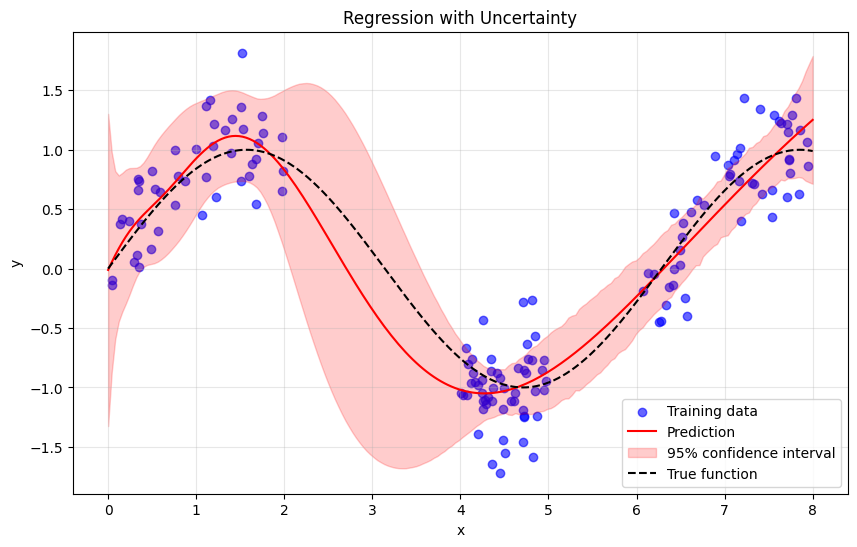

In [74]:
from plotting import print_results

from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS
from laplax.eval.utils import evaluate_metrics_on_dataset

# Set test batch
test_batch = {"input": X_test, "target": y_test}

prob_predictive = set_prob_predictive(prior_arguments={"prior_prec": prior_prec})
results = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,  # How to aggregate metrics over batch.
)


# Print metrics
print_results(results, "Model Evaluation Metrics")

# Predict for plot
X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

### Gradient descent

A major benefit from the gradient descent objective is that we can straightforwardly extend the calibration to other hyperparameters. So far, we were just able to calibrate the prior precision, which will not account properly for the additional observation noise in our regression task. To change this, we will introduce the so-called `sigma` term in our objective, which will support us in modeling the model uncertainty as well. The marginal log-likelihood for the mean squared error loss is then given by:

$$ \log p(\mathcal{D}\vert\mathcal{M}) = \frac{1}{2\sigma}\sum_{n=1}^N (y_n - f(x_n, \theta_*))^2 + \tau \|\theta_*\|^2 - \frac{1}{2} \log \vert \frac{1}{2\pi} \mathrm{H}_{\theta_*}\vert $$

In [75]:
# Initialize prior arguments
prior_arguments = {"prior_prec": jnp.array(1.0), "sigma": jnp.array(0.1)}

In [76]:
from tqdm.auto import tqdm

# Set parameters
num_clbr_epochs = 20
lr = 1e-6

# Set optimizer
optimizer = optax.adam(lr)
opt_state = optimizer.init(prior_arguments)
valid_loader = DataLoader(X_valid, y_valid, batch_size=16)

# Transform prior arguments, so we can optimize over all reals
prior_arguments = jax.tree.map(jnp.log, prior_arguments)

# Optimize prior arguments
with tqdm(total=num_clbr_epochs, desc="Training") as pbar:
    for _ in range(num_clbr_epochs):
        epoch_vals = []
        for batch in valid_loader:
            val, grads = jax.value_and_grad(
                lambda p: objective(
                    jax.tree.map(jnp.exp, p), input_target_split(batch)  # noqa: B023
                )
            )(prior_arguments)

            # Update the parameters using the optimizer
            updates, opt_state = optimizer.update(grads, opt_state)
            prior_arguments = optax.apply_updates(prior_arguments, updates)
            epoch_vals.append(val)

        avg_val = sum(epoch_vals) / len(epoch_vals)
        pbar.set_postfix({'objective': f'{avg_val:.4f}'})
        pbar.update(1)

# Transform prior arguments back
prior_arguments = jax.tree.map(jnp.exp, prior_arguments)

print("Final values:", dict(prior_arguments))

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Final values: {'prior_prec': Array(1.0000714, dtype=float32), 'sigma': Array(0.10000672, dtype=float32)}



Model Evaluation Metrics
----------------------------------------
chi^2 : 0.881090
crps  : 0.224710
nll   : 0.492159
rmse  : 0.325561


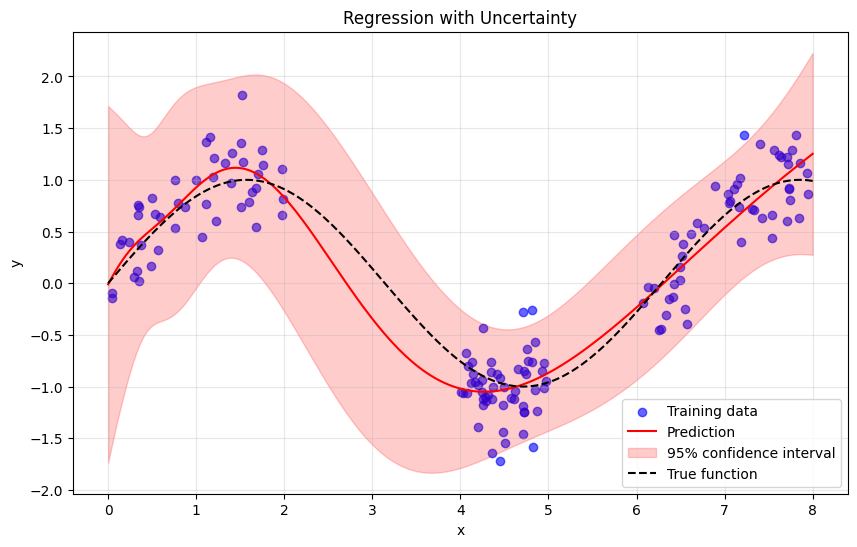

In [77]:
from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS
from laplax.eval.utils import evaluate_metrics_on_dataset

prob_predictive = set_prob_predictive(prior_arguments=prior_arguments)
results = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,  # How to aggregate metrics over batch.
)

# Print metrics
print_results(results, "Model Evaluation Metrics")

# Predict for plot
X_pred = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred,
    y_pred=pred["pred_mean"][:, 0],
    y_std=jnp.sqrt(pred["pred_var"][:, 0])
)

## Bonus: Registering `skerch`

Let us get to some bonus content. One benefit of `laplax` is its modularity, which should make it easy to extend or bend its use cases. For example, we can easily register our favorite curvature approximation method: `skerch`; even though it was written for `torch`. To make it available for creating a posterior function based on its curvature structure, we can either implement (+register) all methods or refer to a default method, which might already exist in `laplax`.

In [78]:
import numpy as np
import torch
from skerch import linops
from skerch.decompositions import seigh

from laplax.curv.utils import LowRankTerms, get_matvec
from laplax.register import register_curvature_method
from laplax.types import DType


class JAXMV(linops.TorchLinOpWrapper):
    def __init__(self, matvec, shape):
        self.shape = shape
        self.matvec = matvec

    def __matmul__(self, x):
        x_dtype = x.dtype
        x = jnp.asarray(x.detach().cpu().numpy())
        x = self.matvec(x)
        return torch.tensor(np.asarray(x), dtype=x_dtype)

    def __rmatmul__(self, x):
        return self.__matmul__(x.T)


def skerch_low_rank(
    A,
    *,
    layout=None,
    rank: int = 100,
    return_dtype: DType = jnp.float64,
    mv_jittable=True,
    **kwargs,
):
    del kwargs
    # Setup mv product.
    matvec, size = get_matvec(A, layout=layout, jit=mv_jittable)
    op = JAXMV(matvec, (size, size))

    res = seigh(
        op, op_device="cpu", op_dtype=torch.float64, outer_dim=rank, inner_dim=rank
    )

    low_rank_result = LowRankTerms(
        U=jnp.asarray((res[0] @ res[1]).detach().cpu()),
        S=jnp.asarray(res[2].detach().cpu().numpy()),
        scalar=jnp.asarray(0.0, dtype=return_dtype),
    )
    return low_rank_result



register_curvature_method(
    name="skerch", create_curvature_fn=skerch_low_rank, default="lanczos"
)

In [79]:
from laplax.curv import create_posterior_fn

posterior_fn = create_posterior_fn(
    curv_type="skerch",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    rank=50,
    mv_jittable=True,
)

/var/folders/kd/3t0zj8gs1zz4f2qpq9dpm0xw0000gn/T/ipykernel_41741/673500682.py:47: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  scalar=jnp.asarray(0.0, dtype=return_dtype),


## Bonus: Posterior GP kernel

We can now use the posterior function to create a Laplace (GP) kernel to also model covariances between various inputs. While the default only takes a single input, we can use standard vectorization techniques to apply it to multiple inputs at the same time.

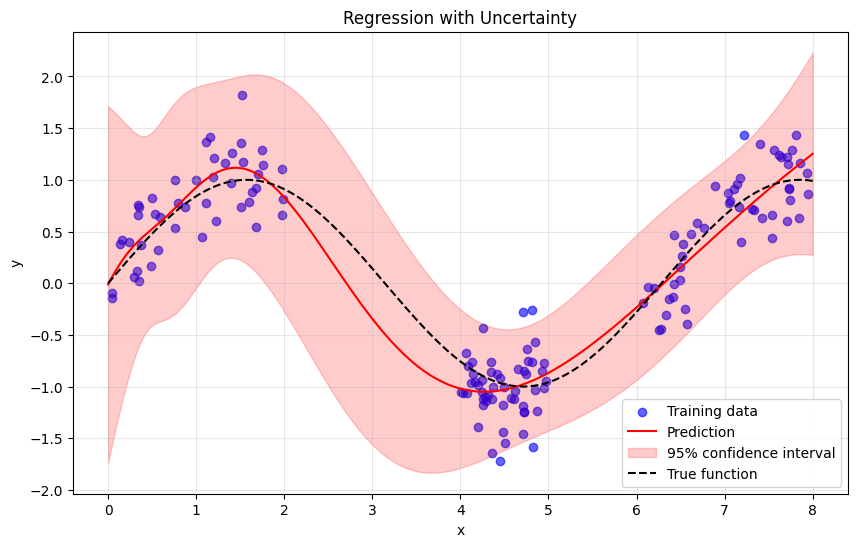

In [80]:
from laplax.eval.pushforward import set_posterior_gp_kernel

gp_kernel, dist_state = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a slower kernel-vector product is returned.
    output_layout=1,
)


def vectorized_laplace_kernel(a, b):
    return jnp.vectorize(gp_kernel, signature="(d),(d)->(j,j)")(a, b)[..., 0]


X_pred = jnp.linspace(0., 8., 200).reshape(200, 1)
Y_pred = model_fn(X_pred, params)[:, 0]
Y_var = vectorized_laplace_kernel(X_pred, X_pred)

_ = plot_regression_with_uncertainty(
    X_train=train_batch["input"],
    y_train=train_batch["target"],
    X_pred=X_pred[:, 0],
    y_pred=Y_pred,
    y_std=jnp.sqrt(Y_var)[:, 0],
)

OK, in this little example this is not so much of an advantage. However, for more complex models/datasets this can be a huge support for downstream tasks.

## Bonus: Model selection

In [81]:
class ModelOverfit(nnx.Module):
    def __init__(self, rngs):
        self.linear1 = nnx.Linear(1, 25, rngs=rngs)
        self.linear2 = nnx.Linear(25, 50, rngs=rngs)
        self.linear3 = nnx.Linear(50, 25, rngs=rngs)
        self.linear4 = nnx.Linear(25, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = nnx.tanh(self.linear3(x))
        x = nnx.tanh(self.linear4(x))
        return x


class FullOverfit(nnx.Module):
    def __init__(self, rngs):
        self.linear1 = nnx.Linear(1, 25, rngs=rngs)
        self.linear2 = nnx.Linear(25, 50, rngs=rngs)
        self.linear3 = nnx.Linear(50, 25, rngs=rngs)
        self.linear4 = nnx.Linear(25, 50, rngs=rngs)
        self.linear5 = nnx.Linear(50, 25, rngs=rngs)
        self.linear6 = nnx.Linear(25, 50, rngs=rngs)
        self.linear7 = nnx.Linear(50, 25, rngs=rngs)
        self.linear8 = nnx.Linear(25, 1, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = nnx.tanh(self.linear2(x))
        x = nnx.tanh(self.linear3(x))
        x = nnx.tanh(self.linear4(x))
        x = nnx.tanh(self.linear5(x))
        x = nnx.tanh(self.linear6(x))
        x = nnx.tanh(self.linear7(x))
        x = nnx.tanh(self.linear8(x))
        return x


n_epochs = 1000
lr = 1e-3
rngs = nnx.Rngs(0)
models = [
    (Model(1, 2, 1, rngs=rngs), 1000, 1e-3, "1-2-1"),
    (Model(1, 50, 1, rngs=rngs), 1000, 1e-3, "1-50-1"),
    (Model(1, 600, 1, rngs=rngs), 1000, 1e-3, "1-600-1"),
    (ModelOverfit(rngs=rngs), n_epochs, 1e-3, "1-25-50-25-1"),
    (FullOverfit(rngs=rngs), n_epochs, 1e-3, "1-25-50-25-50-25-50-25-1"),
]

trained_models = []
for model, num_epoch, lr, name in models:
    print(f"Model {name}")
    model.name = name
    trained_models.append(train_model(model, num_epoch, lr))
    print("-" * 40)

Model 1-2-1
[epoch 0]: loss: 5.9635
[epoch 100]: loss: 6.2015
[epoch 200]: loss: 8.1277
[epoch 300]: loss: 5.1091
[epoch 400]: loss: 8.0070
[epoch 500]: loss: 7.9144
[epoch 600]: loss: 5.4761
[epoch 700]: loss: 7.9413
[epoch 800]: loss: 7.0130
[epoch 900]: loss: 3.6976
Final loss: 6.2531
----------------------------------------
Model 1-50-1
[epoch 0]: loss: 9.9370
[epoch 100]: loss: 5.0796
[epoch 200]: loss: 1.5793
[epoch 300]: loss: 0.9821
[epoch 400]: loss: 2.2806
[epoch 500]: loss: 0.5455
[epoch 600]: loss: 0.8418
[epoch 700]: loss: 0.9990
[epoch 800]: loss: 0.5869
[epoch 900]: loss: 0.7341
Final loss: 0.8031
----------------------------------------
Model 1-600-1
[epoch 0]: loss: 7.7758
[epoch 100]: loss: 1.7799
[epoch 200]: loss: 0.8167
[epoch 300]: loss: 2.1499
[epoch 400]: loss: 0.6092
[epoch 500]: loss: 0.6395
[epoch 600]: loss: 0.9502
[epoch 700]: loss: 1.2497
[epoch 800]: loss: 1.5076
[epoch 900]: loss: 0.6278
Final loss: 0.4323
----------------------------------------
Model 1

In [82]:
marglik = {}
train_batch = {"input": X_train, "target": y_train}
prior_arguments = {"prior_prec": 1.0}
curv_type = "lanczos"

for model in trained_models:
    # Prepare model
    graph_def, params = nnx.split(model)
    def model_fn(input, params):
        return nnx.call((graph_def, params))(input)[0]  # noqa: B023

    curv_approx = estimate_curvature(
        curv_type=curv_type,
        mv=create_ggn_mv(
            model_fn,
            params,
            train_batch,
            loss_fn="mse"
        ),
        layout=params,
        key=jax.random.key(0),  # If necessary
        rank=50,  # If necessary
    )

    marglik[model.name] = marginal_log_likelihood(
        curv_estimate=curv_approx,
        prior_arguments=prior_arguments,
        data=train_batch,
        model_fn=model_fn,
        params=params,
        loss_fn="mse",
        curv_type=curv_type
    ).item()

In [83]:
print_results(marglik, "Marginal log-likelihood")


Marginal log-likelihood
----------------------------------------
1-2-1                    : -61.156006
1-50-1                   : -60.314133
1-600-1                  : -225.644897
1-25-50-25-1             : -89.081299
1-25-50-25-50-25-50-25-1 : -192.647461


We would choose the model with the highest marginal log-likelihood. If there exist additional (continuous/relaxed) model parameters, we could use again the marginal log-likelihood in a gradient-based optimization to find its *optimal* values. Such procedures are often discussed under the name of model selection and differentiable Laplace.